# Deep Learning vs Traditional ML (Logistic Regression) Camprison Notebook

Now that we have trained various LTSM with up to 2 million samples on Google Colab, we are going to compare the results with our traditional ML model (Logistic Regression)

We know that Logistic Regression's performance plateaus after about 200k samples and we know that LSTM is not performing as well as Logistic Regression with only 200k samples. 2 million is around the limit where we can use Google Colab to train our models while still working within the 24 hour backend limit. Further training for LSTM will probably have to be done on GCP using one of the GPU based compute instances.

We will take the results that we have so far to see if it's worth our while to keep training LSTM with more examples on GCP.


## Traditional ML Model

* Model: Logistic Regression
* Class weights: balanced
* Features: TF-IDF with 4k features
* Sample Size: 50k to 9mil

## LSTM Models

| Name | LSTM Units | Spatial Droput between Embedding and LSTM Layer | LSTM Dropout | Sample Size |
|------|--------------|-------------------------------------------------|--------------|-----------|
| LSTMB32 (No Dropout) | 32 | 20% | N/A | 200k to 1mil |
| LSTMB16 (No Dropout) | 16 | 20% | N/A | 200k to 1mil |
| LSTMB16 (Removed All Dropouts) | 16 | N/A | N/A | 200k to 1mil |
| LSTMb64 | 64 | 20% | 20% | 200k to 2mil |
| LSTMB64 (No Dropout) | 64 | 20% | N/A | 200k to 1mil |
| LSTMB128 | 128 | N/A | 0.2 (recurrant) | 50k to 500k |

* Embeding Size: 300
* Early Stop Patience: 4
* Epoch: Up to 20

    
# Conclusion

LSTM with less than 128 cells did not do as well as Logistic Regression model. When we increased LSTM cells to 128, we start seeing the performance of the model exceed logistic regression after 

Starting with just 100k samples, we are seeing LSTM outperform it's Logistic Regression counter part in our custom metric.

When we look closer at the classification report, we are s




In [1]:
# import sibling utilities
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import importlib

import util.dict_util as du
import util.report_util as ru
import util.plot_util as pu

logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set(font_scale=2)


/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Load PySpark LR Report

In [2]:
# load report file form all of our deep learning models
REPORT_DIR = "../reports"
REPORT_LR = f'{REPORT_DIR}/201911-pyspark-report.csv'


report_lr = pd.read_csv(REPORT_LR, quotechar="'")
# flatten out classification report so we can graph later
report_lr = ru.convert_dnn_report_format(report_lr)

# calculate our custom score
report_lr["eval_metric"] = report_lr.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))


ModelWrapper names the reports besed on run date so far. This has to be refactored. Some of the LSTM training was done in 11/2019 and others in 1/2020. Until then, we will merge 2 reports together into one


In [3]:
# runs from 11/2019
REPORT_LSTM_1 = f'{REPORT_DIR}/2019-11-dl_prototype-report.csv'
# runs from 1/2020
REPORT_LSTM_2 = f'{REPORT_DIR}/2020-01-dl_prototype-report.csv'

report_dnn = pd.read_csv(REPORT_LSTM_1, quotechar="'")
report_dnn = report_dnn.append(pd.read_csv(REPORT_LSTM_2, quotechar="'"), ignore_index=True, sort=False)



# report_lstm = report_dnn[(report_dnn.model_name == "LSTMB") & (report_dnn.sampling_type.isna())]
report_lstm64 = report_dnn[(report_dnn.model_name == "LSTMB") & (report_dnn.sampling_type == "none")].copy()
report_lstm64 = ru.convert_dnn_report_format(report_lstm64)

# calculate our custom score
report_lstm64["eval_metric"] = report_lstm64.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))



Runs for LSTMB without dropout was done in 2/2020 so it's in a separate file

In [4]:
REPORT_LSTM_NODROP = f'{REPORT_DIR}/2020-02-dl_prototype-report.csv'

report202002 = pd.read_csv(REPORT_LSTM_NODROP, quotechar="'")
report202002 = ru.convert_dnn_report_format(report202002)
report202002["eval_metric"] = report202002.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))



report_lstm64_nodrop = report202002[report202002.model_name.str.startswith("LSTMB_nodrop")]
report_lstm32 = report202002[report202002.model_name == "LSTMB32"]
report_lstm16 = report202002[report202002.model_name == "LSTMB16"]


report_lstm_removed_all_dropout = pd.read_csv(f'{REPORT_DIR}/lstm_remove_all_dropout-dl_prototype-report.csv', quotechar="'")
report_lstm_removed_all_dropout = ru.convert_dnn_report_format(report_lstm_removed_all_dropout)
report_lstm_removed_all_dropout["eval_metric"] = report_lstm_removed_all_dropout.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))



Added 4/2020 - Load results from LSTM network with 128 nodes

* Glove embedding with 300 dimension vectors
* max sequence length of 100 words (this is same as what we've been doing)
* 128 LSTM hidden units with 0.2 dropout rate
* learning rate of 0.01
* batch size of 32
* 20 epochs with early stopping

In [5]:
# LSTMB128
report_lstmb128 = pd.read_csv(f'{REPORT_DIR}/glove_embedding_with_stop_nonlemmatized-dl_prototype-report.csv', quotechar="'")
report_lstmb128 = report_lstmb128[(report_lstmb128.model_name == "LSTMB128") & (report_lstmb128.feature_set_name == "glove_with_stop_nonlemmatized")]
report_lstmb128 = ru.convert_dnn_report_format(report_lstmb128)
report_lstmb128["eval_metric"] = report_lstmb128.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))

# Accuracy For Various Architectures

Accuracy = Number of Correct Predictions / Total Number of Predictions

When looking at accuracy, our small LSTM models actually performed better than LR as well as LSTM with 128 cells. However, this is misleading since these models tends to predict results into majority class and does not take into account behavior for minority classes since our sample distribution skews heavily towards 5-star reviews.

We want to look at more granular metric that takes into account recall and precision for various classes to get a better sense of how the models are doing

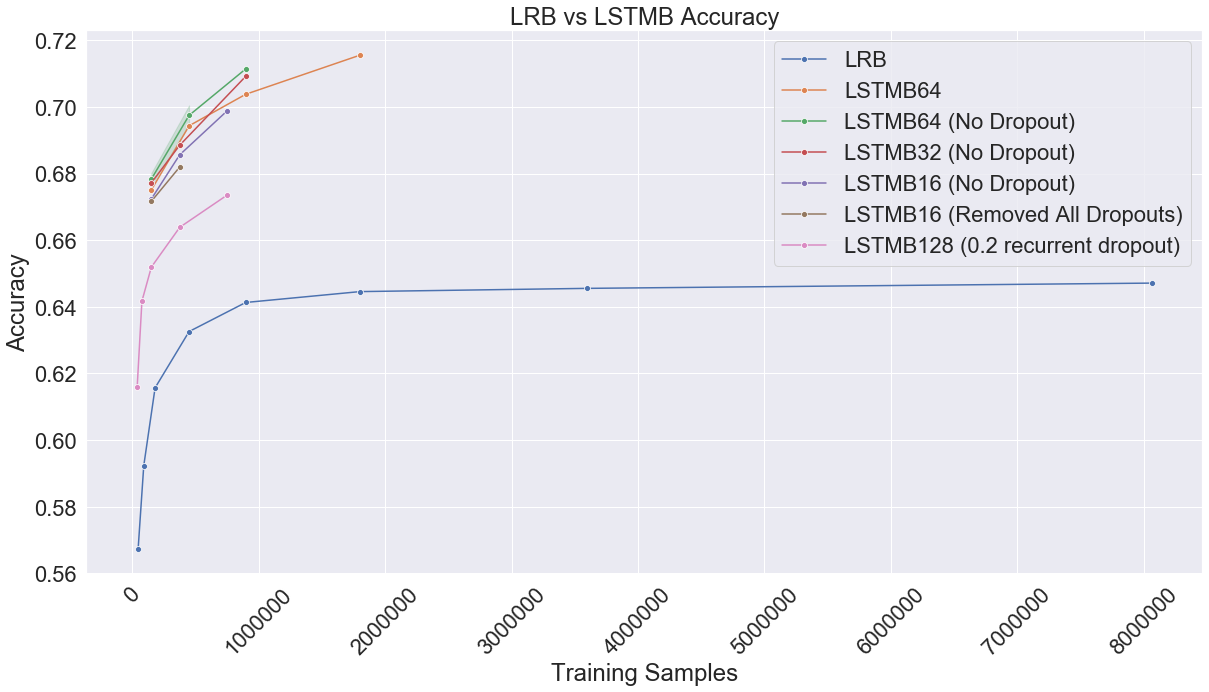

In [6]:
f, a = plt.subplots(1, 1, figsize=(20, 10))
sns.lineplot(data=report_lr, x="train_examples", y="accuracy", marker="o", label="LRB")
sns.lineplot(data=report_lstm64, x="train_examples", y="accuracy", marker="o", label="LSTMB64")
sns.lineplot(data=report_lstm64_nodrop, x="train_examples", y="accuracy", marker="o", label="LSTMB64 (No Dropout)")
sns.lineplot(data=report_lstm32, x="train_examples", y="accuracy", marker="o", label="LSTMB32 (No Dropout)")
sns.lineplot(data=report_lstm16, x="train_examples", y="accuracy", marker="o", label="LSTMB16 (No Dropout)")
sns.lineplot(data=report_lstm_removed_all_dropout, x="train_examples", y="accuracy", marker="o", label="LSTMB16 (Removed All Dropouts)")
sns.lineplot(data=report_lstmb128, x="train_examples", y="accuracy", marker="o", label="LSTMB128 (0.2 recurrent dropout)")
_ = plt.xticks(rotation=45)
_ = plt.xlabel("Training Samples")
_ = plt.ylabel("Accuracy")
_ = plt.title("LRB vs LSTMB Accuracy")




# Custom Metric For Various Architectures

Initial runs of our model tells us that precision and recall for 1-star and 5-star reviews are generally high. However, minority classes (2, 3, 4) generally has low recall.

We want the custom metric to take this into account and help us identify models that balances between precision for majority classes and increase recall for minority classes.

We define our custom metric as the harmonic mean of 1-star precision, 2-star recall, 3-star recall, 4-star recall, and 5-star precision

Once we take these into account, you see that LSTM with 128 cells out performs all models with only 500k samples and our smaller LSTM networks actually did not do very well because recall for minority classes is actually lower than other models.


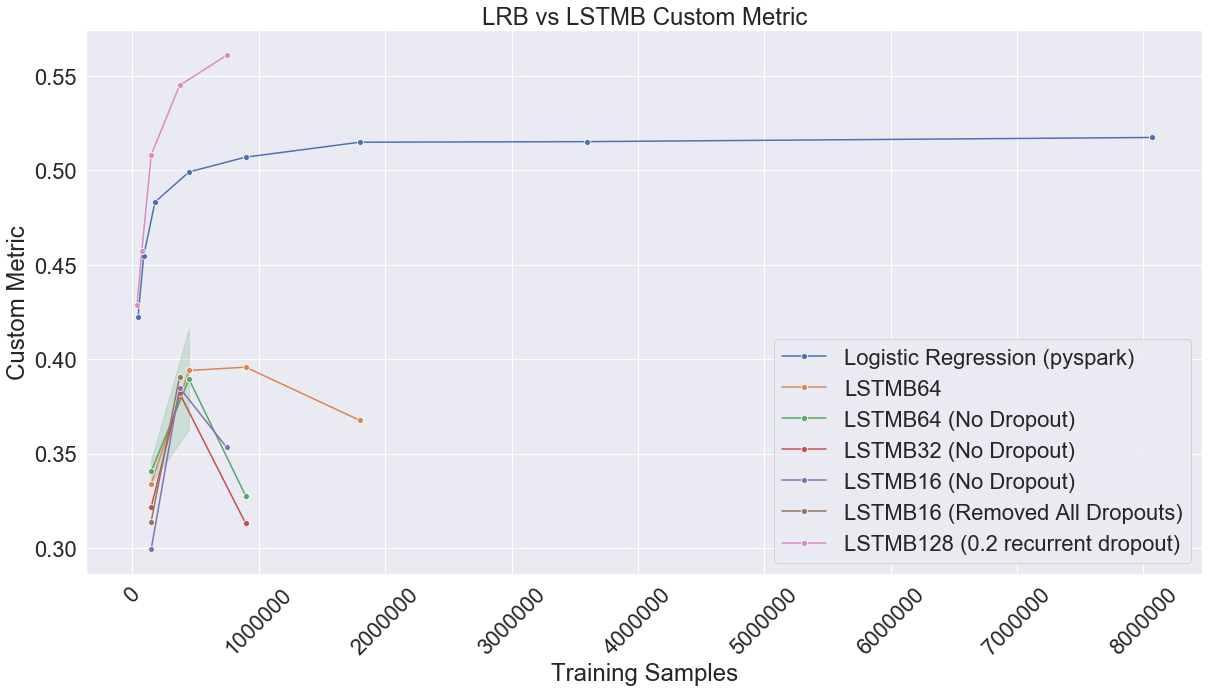

In [7]:
f, a = plt.subplots(1, 1, figsize=(20, 10))
sns.lineplot(data=report_lr, x="train_examples", y="eval_metric", marker="o", label="Logistic Regression (pyspark)")
sns.lineplot(data=report_lstm64, x="train_examples", y="eval_metric", marker="o", label="LSTMB64")
sns.lineplot(data=report_lstm64_nodrop, x="train_examples", y="eval_metric", marker="o", label="LSTMB64 (No Dropout)")
sns.lineplot(data=report_lstm32, x="train_examples", y="eval_metric", marker="o", label="LSTMB32 (No Dropout)")
sns.lineplot(data=report_lstm16, x="train_examples", y="eval_metric", marker="o", label="LSTMB16 (No Dropout)")
sns.lineplot(data=report_lstm_removed_all_dropout, x="train_examples", y="eval_metric", marker="o", label="LSTMB16 (Removed All Dropouts)")
sns.lineplot(data=report_lstmb128, x="train_examples", y="eval_metric", marker="o", label="LSTMB128 (0.2 recurrent dropout)")
_ = plt.xticks(rotation=45)
_ = plt.xlabel("Training Samples")
_ = plt.ylabel("Custom Metric")
_ = plt.title("LRB vs LSTMB Custom Metric")




### Custom Metrics

In [8]:
print("Logistic Regression")
report_lr[["train_examples", "eval_metric"]]

Logistic Regression


,train_examples,eval_metric
0,44726.0,0.422127
1,89544.0,0.454550
2,179168.0,0.483252
3,447989.0,0.499181
4,896004.0,0.507036
5,1799736.0,0.514962
6,3599433.0,0.515266
7,8064337.0,0.517467


In [9]:
print("LSTM with 64 cells")
report_lstm64[["train_examples", "eval_metric"]].sort_values("train_examples")

LSTM with 64 cells


,train_examples,eval_metric
0,149350.0,0.333960
2,448051.0,0.394009
3,896119.0,0.395784
1,1800000.0,0.367591


In [10]:
print("LSTM with 128 cells")
report_lstmb128[["train_examples", "eval_metric"]].sort_values("train_examples")

LSTM with 128 cells


,train_examples,eval_metric
1,37415.0,0.428784
3,74829.0,0.457150
0,149653.0,0.508309
2,374123.0,0.545078
4,748261.0,0.561074


# Classification Between Logistic Regression and LSTM (128 cells)

REMINDER: we are using precision for 1-star and 5-star, and recall for 2-star, 3-star, and 4-star reviews to calculate our custom metric. Tradtionally, we have seen that increasing 2-star recall has been challenging, mostly because we have the least amount of samples available to use for training in this category

* generally we are seeing 2-star, 3-star, 4-star recall increase as we provide more samples for training for LSTMB
* Staring around 500k samples, we see that LSTMB precision for 1-star reviews starts to exceed LRB
* Recall for 2-star reviews with just 50k samples is around the same as training LRB with 9mil examples and stars to exceed LRB with just 100k examples
* 3-star recall starts to exceed LRB around 200k samples and was approximately the same as we increased to 500k samples
* 4-star recall with 500k samples for LSTMB is roughly the same as training LRB with 9mil examples
* Precision for 5-star reviews are roughly the same between LRB and LSTMB

Also, another thing interesting to note, starting at around 500k samples for LSTMB, we are seeing 2-star review recall exceeding 3-star and 4-star recall that we have not seen before.

Logistic Regression (Balanced Weight) with 9 Million Examples


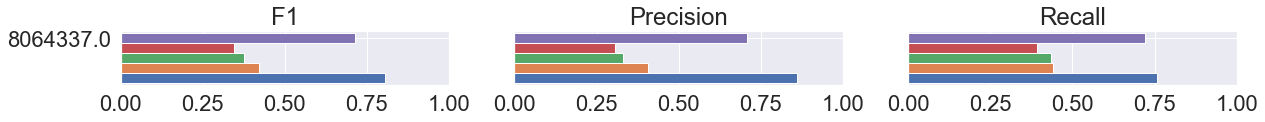

In [11]:
import util.plot_util as pu
print("Logistic Regression (Balanced Weight) with 9 Million Examples")
pu.plot_score_histograms(report_lr[report_lr.train_examples == report_lr.train_examples.max()], version=2, label="train_examples")

LSTM (128 Units 20% Recurrent Dropout)


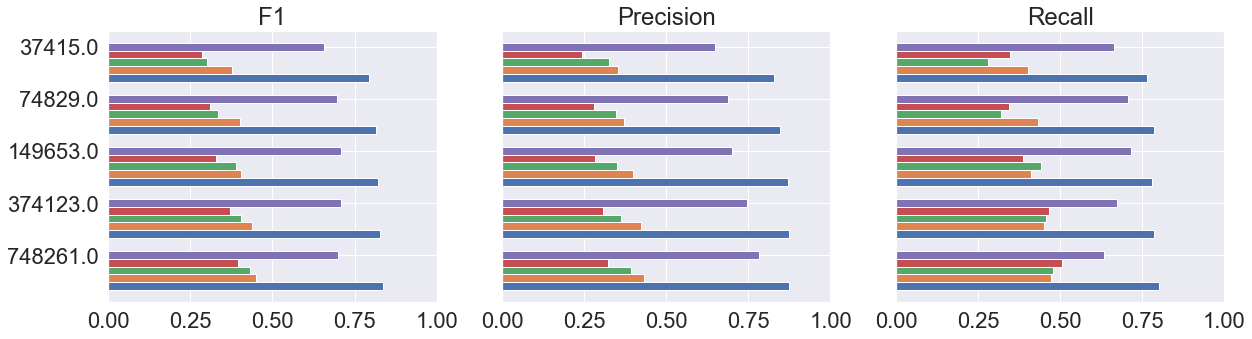

In [12]:
print("LSTM (128 Units 20% Recurrent Dropout)")
pu.plot_score_histograms(report_lstmb128, version=2, label="train_examples")

# LSTM Parameter Tuning (128 cells)

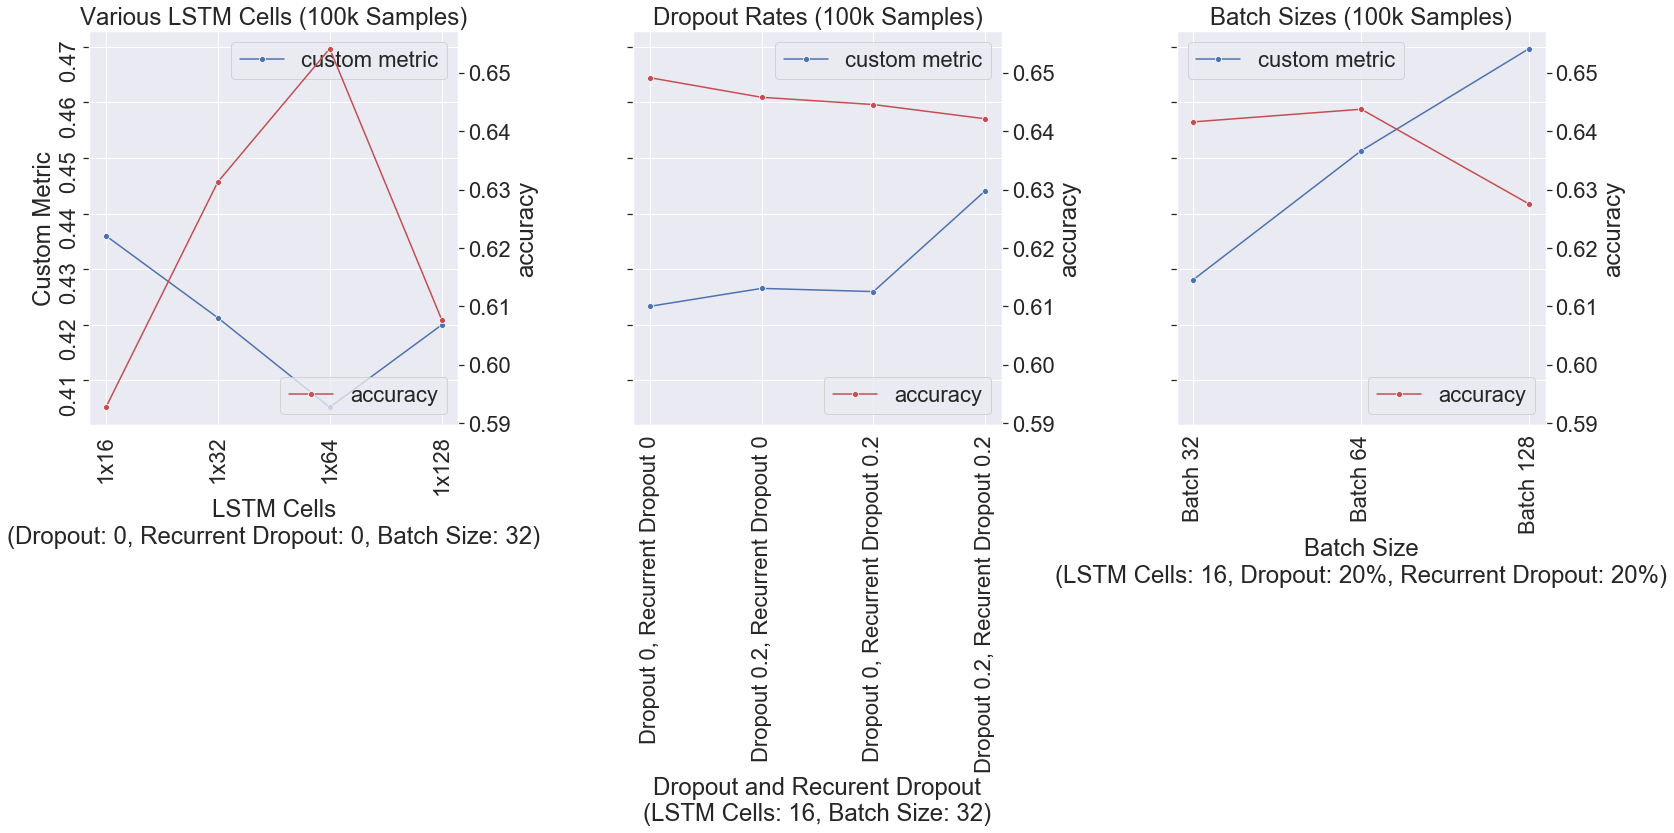

In [13]:
# get baseline for our tests - 100k samples (74829 train examples)
report_lstmb128_baseline = report_lstmb128[(report_lstmb128.train_examples == 74829)]

f, a = plt.subplots(1, 3, figsize=(25, 10), sharey=True)
f.tight_layout(pad=6.0)




#################### Graph Cell

report_cell_tuning = pd.read_csv(f'{REPORT_DIR}/LSTM-cell-tuning-report.csv', quotechar="'")
report_cell_tuning = ru.convert_dnn_report_format(report_cell_tuning)
report_cell_tuning["eval_metric"] = report_cell_tuning.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))
report_cell_tuning


graph = sns.lineplot(data=report_cell_tuning, x="architecture", y="eval_metric", marker="o", label="custom metric", sort=False, ax=a[0])
_ = a[0].set_ylabel("Custom Metric")
_ = a[0].set_xlabel("LSTM Cells\n(Dropout: 0, Recurrent Dropout: 0, Batch Size: 32)")


_ = a[0].tick_params(labelrotation=90)
_ = a[0].set_title("Various LSTM Cells (100k Samples)")

# _ = a.axhline(report_lstmb128_baseline.eval_metric.values[0], linestyle="--", color="r", label="baseline")

a1 = a[0].twinx()
graph = sns.lineplot(data=report_cell_tuning, x="architecture", y="accuracy", marker="o", label="accuracy", sort=False, color="r", ax=a1)
_ = a1.grid(False)
_ = plt.legend(loc='lower right')


#################### Graph Dropout

report_dropout_tuning = pd.read_csv(f'{REPORT_DIR}/LSTM-dropout-tuning-report.csv', quotechar="'")
report_dropout_tuning = ru.convert_dnn_report_format(report_dropout_tuning)
report_dropout_tuning["eval_metric"] = report_dropout_tuning.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))
report_dropout_tuning


graph = sns.lineplot(data=report_dropout_tuning, x="description", y="eval_metric", marker="o", label="custom metric", sort=False, ax=a[1])
_ = a[1].set_ylabel("Custom Metric")
_ = a[1].set_xlabel("Dropout and Recurent Dropout\n(LSTM Cells: 16, Batch Size: 32)")


# _ = plt.xticks(rotation=90)
_ = a[1].tick_params(labelrotation=90)
_ = a[1].set_title("Dropout Rates (100k Samples)")

a2 = a[1].twinx()
# align secondary y axes (accuracy)
_ = a1.get_shared_y_axes().join(a1, a2)

graph = sns.lineplot(data=report_dropout_tuning, x="description", y="accuracy", marker="o", label="accuracy", sort=False, color="r", ax=a2)
_ = a2.grid(False)
_ = plt.legend(loc='lower right')


#################### Graph Batch Sizes

report_batch_tuning = pd.read_csv(f'{REPORT_DIR}/LSTM-batch-tuning-report.csv', quotechar="'")
report_batch_tuning = ru.convert_dnn_report_format(report_batch_tuning)
report_batch_tuning["eval_metric"] = report_batch_tuning.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))
report_batch_tuning


graph = sns.lineplot(data=report_batch_tuning, x="description", y="eval_metric", marker="o", label="custom metric", sort=False, ax=a[2])
_ = a[2].set_ylabel("Custom Metric")
_ = a[2].set_xlabel("Batch Size\n(LSTM Cells: 16, Dropout: 20%, Recurrent Dropout: 20%)")

# _ = plt.xticks(rotation=90)
_ = a[2].tick_params(labelrotation=90)
_ = a[2].set_title("Batch Sizes (100k Samples)")

a3 = a[2].twinx()
# align secondary y axes (accuracy)
_ = a2.get_shared_y_axes().join(a2, a3)

graph = sns.lineplot(data=report_batch_tuning, x="description", y="accuracy", marker="o", label="accuracy", sort=False, color="r", ax=a3)
_ = a3.grid(False)
_ = plt.legend(loc='lower right')

